# 14.32 final paper

## Setup

In [42]:
# !pip install linearmodels

     |████████████████████████████████| 1.5 MB 3.7 MB/s eta 0:00:01
     |████████████████████████████████| 231 kB 12.3 MB/s eta 0:00:01
     |████████████████████████████████| 8.7 MB 5.1 MB/s eta 0:00:01     |█████████████▎                  | 3.6 MB 5.1 MB/s eta 0:00:01


In [150]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import microdf as mdf
import matplotlib.pyplot as plt
from linearmodels.panel import PanelOLS

In [148]:
mdf.set_plot_style()

## Load data

In [167]:
cases_raw = pd.read_csv('https://github.com/nytimes/covid-19-data/raw/master/us-counties.csv')

In [2]:
closures_raw = pd.read_csv('https://raw.githubusercontent.com/Keystone-Strategy/covid19-intervention-data/a41e4f282fab31793d01923c7d7445e45bddbbe0/complete_npis_inherited_policies.csv')

In [296]:
pop_raw = pd.read_csv('https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv',
                      usecols=['STATE', 'COUNTY', 'POPESTIMATE2019'])

In [3]:
cps_raw = pd.read_csv('cps.csv.gz')

## Preprocess

### Population

In [297]:
pop = pop_raw.copy(deep=True)
pop['county_padded'] = pop.COUNTY.apply(lambda x: str(x).zfill(3))
pop['fips'] = (pop.STATE.astype(str) + pop.county_padded).astype(int)

In [298]:
county_pop = pop[pop.COUNTY > 0][['fips', 'POPESTIMATE2019']]
state_pop = pop[pop.COUNTY == 0][['STATE', 'POPESTIMATE2019']]
state_pop.rename({'STATE': 'fips'}, axis=1, inplace=True)

### Cases

In [347]:
cases = cases_raw[cases_raw.date >= '2020-03-01'][
    ['date', 'fips', 'cases', 'deaths']].copy(deep=True)

In [348]:
cases.date = pd.to_datetime(cases.date)

In [349]:
cases = cases.merge(county_pop, on='fips')

In [350]:
cases.rename({'fips': 'COUNTY'}, axis=1, inplace=True)

In [351]:
cases = cases.merge(closures, on='COUNTY')

In [352]:
cases['cases_pc'] = cases.cases / cases.POPESTIMATE2019
cases['deaths_pc'] = cases.deaths / cases.POPESTIMATE2019

Add 1 since deaths are zero sometimes, and multiple by million for variation in the feature.

In [388]:
cases['log_cases_pc'] = np.log(cases.cases_pc * 1e6 + 1)
cases['log_deaths_pc'] = np.log(cases.deaths_pc * 1e6 + 1)

In [389]:
cases

,const,date,COUNTY,cases,deaths,POPESTIMATE2019,school_closure_date,cases_pc,deaths_pc,log_cases_pc,log_deaths_pc,school_closure_date_num
0,1.0,2020-03-01,4013.0,1,0,4485414,2020-03-15,2.229449e-07,0.000000,0.201262,0.000000,3
1,1.0,2020-03-02,4013.0,1,0,4485414,2020-03-15,2.229449e-07,0.000000,0.201262,0.000000,3
2,1.0,2020-03-03,4013.0,2,0,4485414,2020-03-15,4.458897e-07,0.000000,0.368725,0.000000,3
3,1.0,2020-03-04,4013.0,2,0,4485414,2020-03-15,4.458897e-07,0.000000,0.368725,0.000000,3
4,1.0,2020-03-05,4013.0,2,0,4485414,2020-03-15,4.458897e-07,0.000000,0.368725,0.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...
25429,1.0,2020-05-23,44007.0,10519,342,638931,2020-03-16,1.646344e-02,0.000535,9.708958,6.284636,4
25430,1.0,2020-05-24,44007.0,10607,342,638931,2020-03-16,1.660117e-02,0.000535,9.717288,6.284636,4
25431,1.0,2020-05-25,44007.0,10607,342,638931,2020-03-16,1.660117e-02,0.000535,9.717288,6.284636,4
25432,1.0,2020-05-26,44007.0,10607,342,638931,2020-03-16,1.660117e-02,0.000535,9.717288,6.284636,4


## First stage

In [390]:
cases['school_closure_date_num'] = (
    cases.school_closure_date - first_closure_date).dt.days
cases = sm.add_constant(cases)

In [391]:
def get_t(cases, var):
    regs = sm.WLS(cases.school_closure_date_num,
                  cases[[var, 'const']],
                  weights=cases.POPESTIMATE2019).fit().summary()
    return float(regs.tables[1][1].data[3])

In [392]:
def get_ts(cases):
    return pd.Series([get_t(cases, 'cases'), get_t(cases, 'deaths'),
                      get_t(cases, 'cases_pc'), get_t(cases, 'deaths_pc'),
                      get_t(cases, 'log_cases_pc'),
                      get_t(cases, 'log_deaths_pc')],
                     index=['cases', 'deaths', 'cases_pc', 'deaths_pc',
                            'log_cases_pc', 'log_deaths_pc'])

In [393]:
fs_df = cases[cases.date.between('2020-03-01', '2020-03-31')].groupby(
    'date').apply(get_ts)

In [394]:
fs_df

,cases,deaths,cases_pc,deaths_pc,log_cases_pc,log_deaths_pc
date,,,,,,
2020-03-01,-2.411,-2.246,-1.574,-2.246,-2.623,-2.246
2020-03-02,-2.497,-2.327,-1.952,-2.327,-2.978,-2.327
2020-03-03,-3.172,-2.426,-2.567,-2.426,-3.914,-2.426
2020-03-04,-1.519,-2.564,-2.465,-2.511,-2.655,-2.457
2020-03-05,-1.435,-2.704,-2.672,-2.663,-2.490,-2.614
2020-03-06,-1.013,-3.026,-2.211,-2.973,-2.232,-2.866
2020-03-07,-0.925,-3.120,-1.518,-3.094,-2.213,-2.991
2020-03-08,-0.945,-3.032,-1.462,-3.004,-2.023,-2.899
2020-03-09,-1.110,-3.021,-1.655,-3.001,-2.118,-2.816


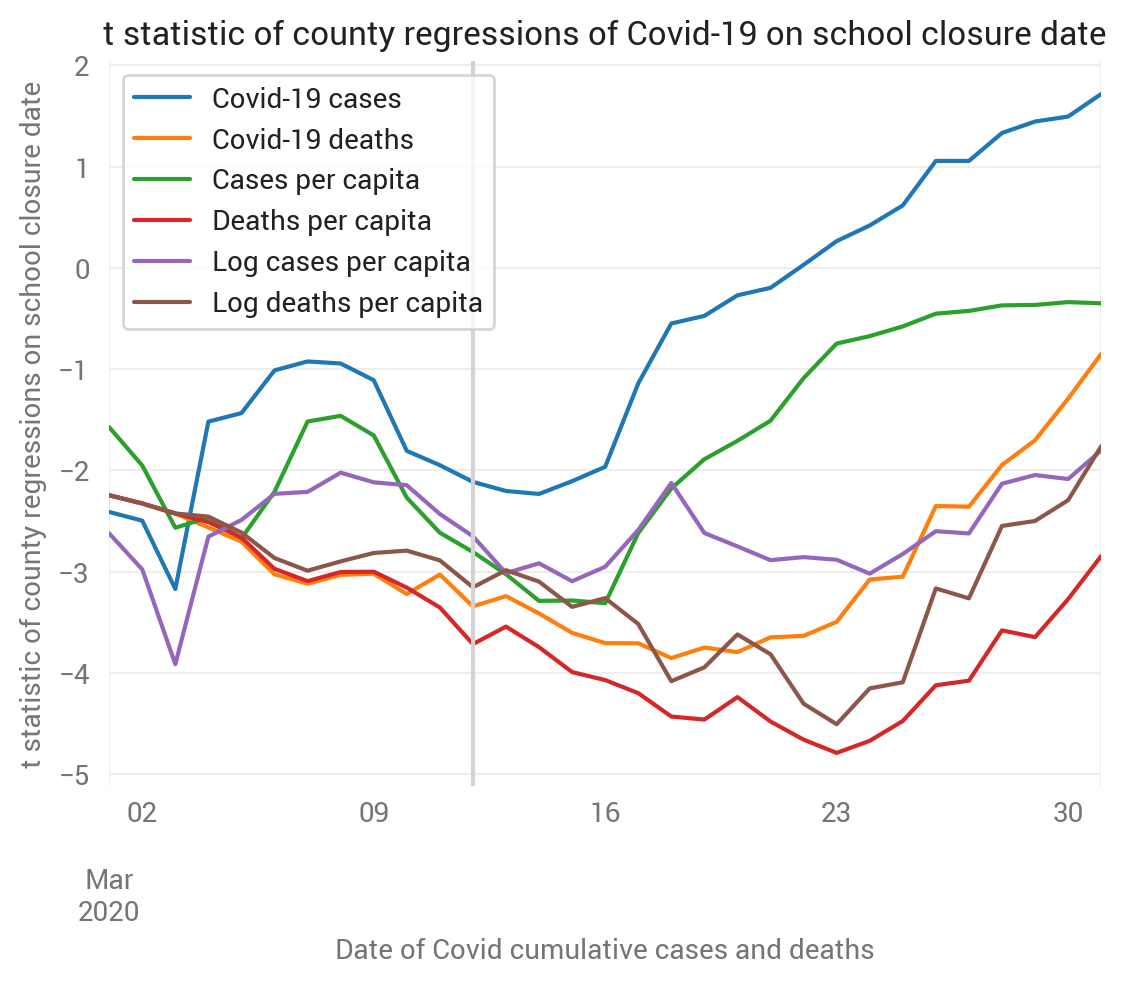

In [397]:
ax = fs_df.plot()
plt.title('t statistic of county regressions of Covid-19 on school closure date')
ax.axvline('2020-03-12', c='lightgray')
plt.xlabel('Date of Covid cumulative cases and deaths')
plt.ylabel('t statistic of county regressions on school closure date')
plt.legend(['Covid-19 cases', 'Covid-19 deaths',
            'Cases per capita', 'Deaths per capita',
            'Log cases per capita', 'Log deaths per capita'])
plt.show()

In [337]:
min_t_cases = fs_df.iloc[:11].sort_values('cases_pc').iloc[0]
min_t_deaths = fs_df.iloc[:11].sort_values('deaths_pc').iloc[0]
min_t = min(min_t_cases.cases_pc, min_t_deaths.deaths_pc)
if min_t == min_t_cases.cases_pc:
    min_t_metric = 'cases_pc'
    min_t_date = min_t_cases.name
else:
    min_t_metric = 'deaths_pc'
    min_t_date = min_t_deaths.name

In [338]:
min_t_date

Timestamp('2020-03-07 00:00:00')

In [377]:
cases_min_t_date = cases[cases.date == min_t_date]

In [387]:
(cases.deaths_pc / cases.log_deaths_pc).describe()

count    20722.000000
mean         1.000091
std          0.000145
min          1.000000
25%          1.000009
50%          1.000031
75%          1.000103
max          1.001016
dtype: float64

In [383]:
sm.WLS(cases_min_t_date.school_closure_date_num,
       cases_min_t_date[['deaths_pc', 'log_deaths_pc', 'const']],
       cases_min_t_date.POPESTIMATE2019).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               WLS Regression Results                              
===================================================================================
Dep. Variable:     school_closure_date_num   R-squared:                       0.122
Model:                                 WLS   Adj. R-squared:                  0.097
Method:                      Least Squares   F-statistic:                     4.794
Date:                     Thu, 28 May 2020   Prob (F-statistic):             0.0112
Time:                             22:37:22   Log-Likelihood:                -162.08
No. Observations:                       72   AIC:                             330.2
Df Residuals:                           69   BIC:                             337.0
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
deaths_pc     -1.602e+11   4.36e+11     -0.368      0.714   -1.03e+12    7.09e+11
log_deaths_pc  1.602e+11   4.36e+11      0.368      0.714   -7.09e+11    1.03e+12
const             4.3870      0.229     19.123      0.000       3.929       4.845
==============================================================================
Omnibus:                       34.955   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              154.884
Skew:                           1.274   Prob(JB):                     2.33e-34
Kurtosis:                       9.718   Cond. No.                     2.74e+12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.16e-17. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

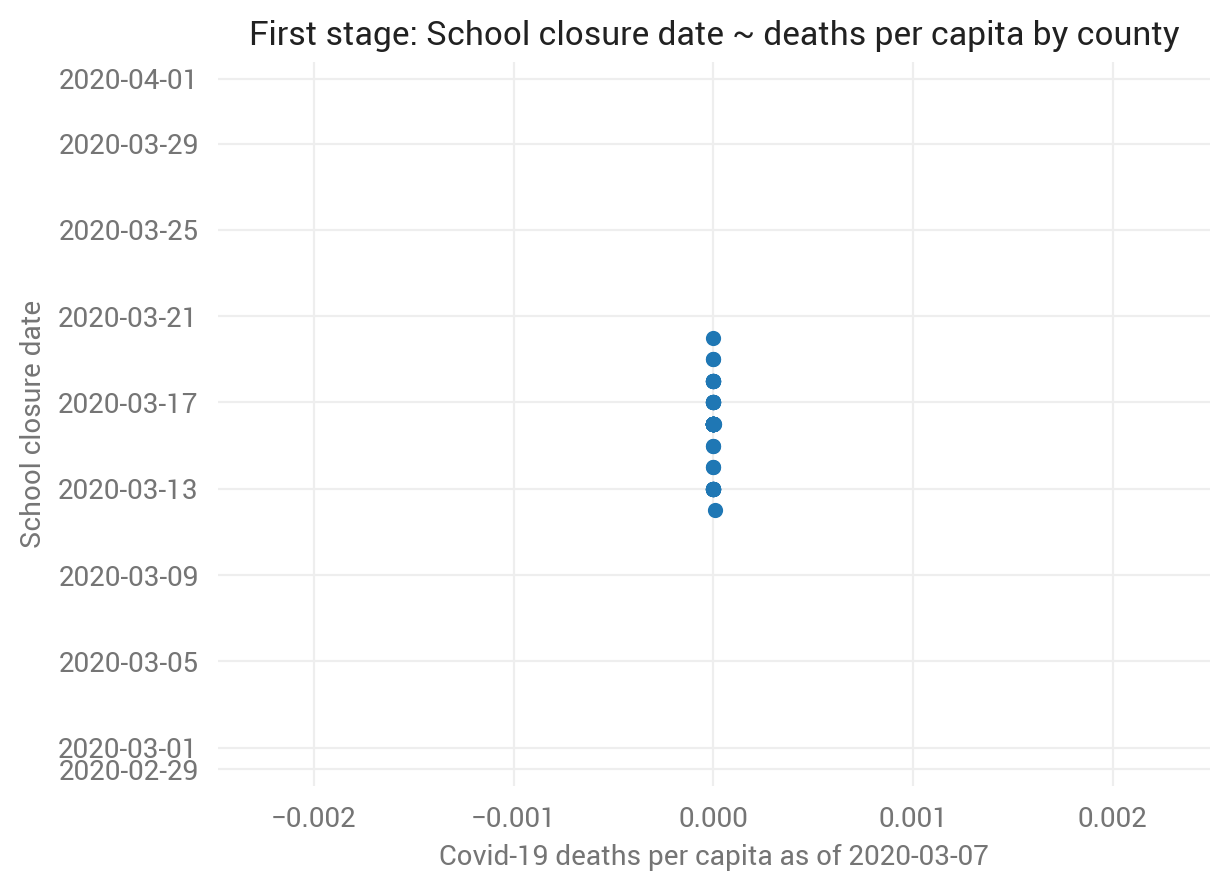

In [342]:
cases_min_t_date.plot.scatter(x='deaths_pc', y='school_closure_date')
plt.title('First stage: School closure date ~ deaths per capita by county')
plt.xlabel('Covid-19 deaths per capita as of 2020-03-07')
plt.ylabel('School closure date')
plt.show()

### School closures

In [4]:
closures = closures_raw[
    (closures_raw.npi == 'school_closure') & ~closures_raw.county.isna()][
    ['fip_code', 'start_date']]

In [5]:
closures.start_date = pd.to_datetime(closures.start_date)
closures.columns = ['COUNTY', 'school_closure_date']

### Merge

In [6]:
cps = cps_raw.merge(closures, on='COUNTY')

In [8]:
cps['female'] = cps.SEX == 2

Add date corresponding to the final survey week of each month.

In [61]:
cps['day'] = 12
cps['cps_date'] = pd.to_datetime(cps[['YEAR', 'MONTH', 'day']])
# Day of the week to find the following Saturday.
# Series.dt.weekday is 0 for Monday, 6 for Sunday.
cps['cps_weekday'] = cps.cps_date.dt.weekday
cps['days_to_sat'] = np.where(cps.cps_weekday == 6, 12, 5) - cps.cps_weekday
cps['cps_date'] = cps.cps_date + cps.days_to_sat.astype('timedelta64[D]')
# Drop unnecessary intermediate columns.
cps.drop(['day', 'cps_weekday', 'days_to_sat'], axis=1, inplace=True)

https://cps.ipums.org/cps-action/variables/EMPSTAT#codes_section

In [62]:
cps['unemp'] = cps.EMPSTAT.isin([20, 21, 22])
cps['emp'] = cps.EMPSTAT.isin([10, 12])
cps['lf'] = cps.unemp | cps.emp

In [64]:
cps = cps[cps.WTFINL > 0]

In [68]:
cps['has_k6'] = cps.NCHILD > cps.NCHLT5

In [67]:
cps['post'] = cps.cps_date >= cps.school_closure_date

In [70]:
cps['post_has_k6'] = cps.post & cps.has_k6

In [73]:
cps['cps_date_float'] = cps.cps_date.values.astype(float)

In [65]:
cps = sm.add_constant(cps)

## Exploration

In [ ]:
cps.NCHLT5.value_counts()

In [79]:
cps.post.value_counts()

False    349666
True      14102
Name: post, dtype: int64

In [97]:
cps.school_closure_date.value_counts()

2020-03-16    188517
2020-03-17     39050
2020-03-19     34718
2020-03-13     32064
2020-03-18     23075
2020-03-15     21516
2020-03-23     12397
2020-03-12      5137
2020-03-20      3041
2020-04-02      2146
2020-03-14      2107
Name: school_closure_date, dtype: int64

In [78]:
cps.cps_date_float.value_counts()

1.539389e+18    16035
1.536970e+18    16028
1.542413e+18    15932
1.544832e+18    15757
1.547251e+18    15743
1.529107e+18    15738
1.526083e+18    15736
1.531526e+18    15678
1.534550e+18    15668
1.550275e+18    15513
1.555114e+18    15341
1.581725e+18    15230
1.552694e+18    15112
1.558138e+18    15032
1.560557e+18    15012
1.576282e+18    15005
1.566000e+18    14992
1.579306e+18    14955
1.573862e+18    14876
1.568419e+18    14852
1.570838e+18    14801
1.562976e+18    14785
1.584144e+18    13324
1.587168e+18    12623
Name: cps_date_float, dtype: int64

In [91]:
cps.groupby(['MONTH', 'post']).size()

MONTH  post 
1      False    30698
2      False    30743
3      False    26957
       True      1479
4      False    15341
       True     12623
5      False    30768
6      False    30750
7      False    30463
8      False    30660
9      False    30880
10     False    30836
11     False    30808
12     False    30762
dtype: int64

In [101]:
cps[cps.MONTH.isin([3,4])].groupby(['MONTH', 'post', 'cps_date']).size()

MONTH  post   cps_date  
3      False  2019-03-16    15112
              2020-03-14    11845
       True   2020-03-14     1479
4      False  2019-04-13    15341
       True   2020-04-18    12623
dtype: int64

## Instrument

Instrument for school closure using employment rate of mothers as of January 2020.

In [116]:
cps['mother'] = cps.female & cps.has_k6
cps['emp_mother'] = cps.mother & cps.emp

In [118]:
cps_jan2020_mothers = cps[(cps.YEAR == 2020) & (cps.MONTH == 1) & cps.mother]

In [137]:
county_mother_emp_jan2020 = cps_jan2020_mothers.groupby('COUNTY').apply(
    lambda x: mdf.weighted_mean(x, 'emp_mother', 'WTFINL')
)

In [138]:
county_mother_emp_jan2020

COUNTY
1081     0.628143
1097     0.571985
4013     0.684050
4019     0.721787
4021     0.697512
           ...   
51810    0.689221
53033    0.793347
53057    0.478584
53061    0.655229
55059    1.000000
Length: 171, dtype: float64

In [139]:
county_mother_emp_jan2020 = pd.DataFrame(county_mother_emp_jan2020)
county_mother_emp_jan2020.columns = ['mother_emp_jan2020']

In [141]:
closures_mother_emp = closures.merge(county_mother_emp_jan2020, on='COUNTY')

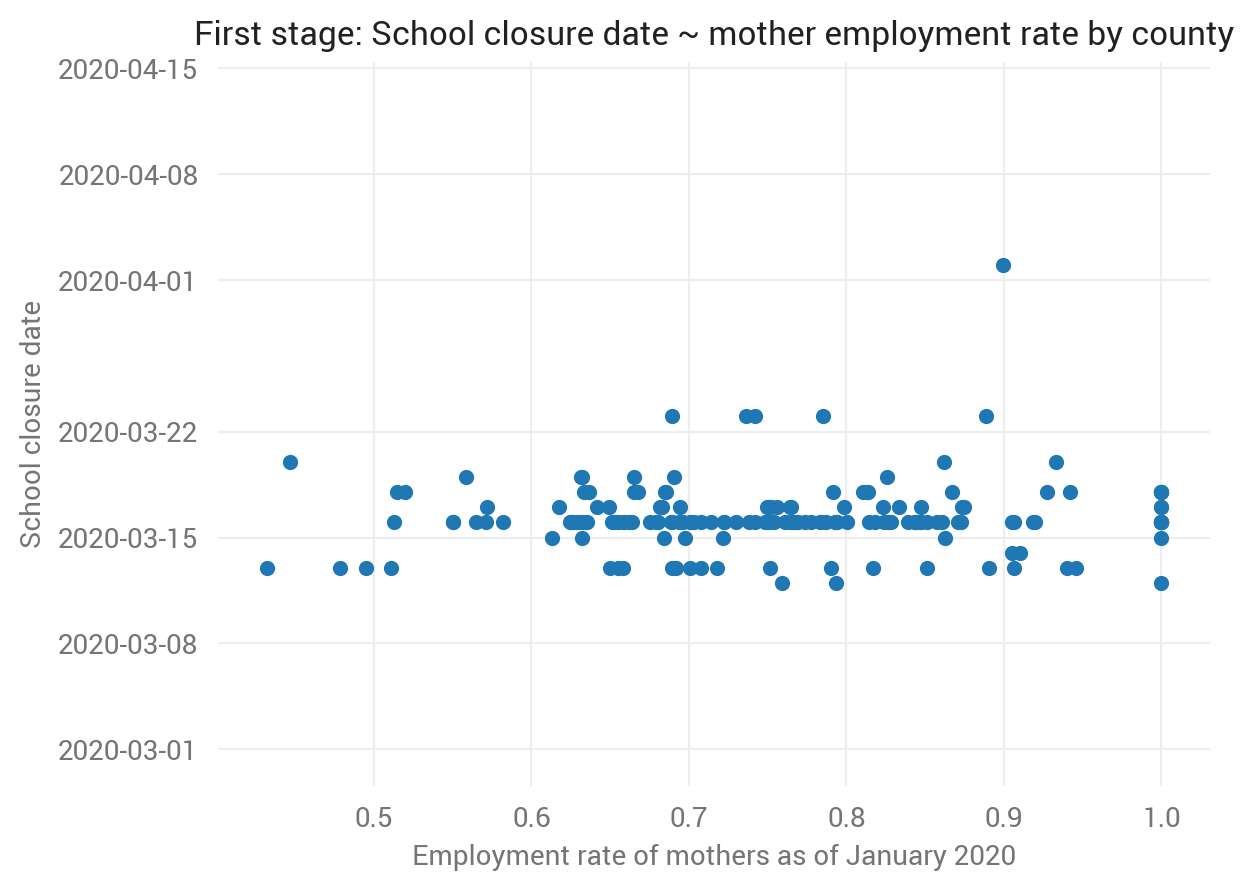

In [165]:
closures_mother_emp.plot.scatter(x='mother_emp_jan2020', y='school_closure_date')
plt.title('First stage: School closure date ~ mother employment rate by county')
plt.xlabel('Employment rate of mothers as of January 2020')
plt.ylabel('School closure date')
plt.show()

In [158]:
first_closure_date = closures.school_closure_date.min()

In [163]:
closures_mother_emp['school_closure_date_num'] = (
    closures_mother_emp.school_closure_date - first_closure_date).dt.days
closures_mother_emp = sm.add_constant(closures_mother_emp)

In [166]:
closures_mother_emp.describe()

,const,COUNTY,mother_emp_jan2020,school_closure_date_num
count,171.0,171.000000,171.000000,171.000000
mean,1.0,25665.409357,0.757952,4.339181
std,0.0,14431.194731,0.128465,2.371804
min,1.0,1081.000000,0.431955,0.000000
25%,1.0,12102.000000,0.666277,4.000000
50%,1.0,25015.000000,0.752391,4.000000
75%,1.0,36089.000000,0.845696,5.000000
max,1.0,55059.000000,1.000000,21.000000


In [164]:
sm.OLS(closures_mother_emp.school_closure_date_num,
       closures_mother_emp[['mother_emp_jan2020', 'const']]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     school_closure_date_num   R-squared:                       0.004
Model:                                 OLS   Adj. R-squared:                 -0.002
Method:                      Least Squares   F-statistic:                    0.7248
Date:                     Thu, 28 May 2020   Prob (F-statistic):              0.396
Time:                             17:19:49   Log-Likelihood:                -389.46
No. Observations:                      171   AIC:                             782.9
Df Residuals:                          169   BIC:                             789.2
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
mother_emp_jan2020     1.2065      1.417      0.851      0.396      -1.591       4.004
const                  3.4247      1.089      3.144      0.002       1.274       5.575
==============================================================================
Omnibus:                      119.172   Durbin-Watson:                   1.652
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1491.287
Skew:                           2.354   Prob(JB):                         0.00
Kurtosis:                      16.680   Cond. No.                         12.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [153]:
closures_mother_emp.corr()

,COUNTY,mother_emp_jan2020
COUNTY,1.000000,0.106512
mother_emp_jan2020,0.106512,1.000000


## Regressions

In [93]:
cps[cps.post].cps_date.value_counts()

2020-04-18    12623
2020-03-14     1479
Name: cps_date, dtype: int64

In [96]:
cps.COUNTY.isna().sum()

0

In [94]:
cps.COUNTY.value_counts()

6037     27892
11001    20158
4013     11089
32003    11082
15003    10560
         ...  
13045      297
53061      296
24017      279
34019      265
13015      244
Name: COUNTY, Length: 171, dtype: int64

In [89]:
cps.groupby(['has_k6', 'post']).size()

has_k6  post 
False   False    195480
        True       7852
True    False    154186
        True       6250
dtype: int64

In [102]:
cps.columns

Index(['const', 'YEAR', 'SERIAL', 'MONTH', 'HWTFINL', 'CPSID', 'COUNTY',
       'FAMINC', 'WTFINL', 'CPSIDP', 'AGE', 'SEX', 'MARST', 'NCHILD', 'NCHLT5',
       'EMPSTAT', 'AHRSWORKT', 'EARNWEEK', 'school_closure_date', 'female',
       'cps_date', 'unemp', 'emp', 'lf', 'post', 'has_k6', 'post_has_k6',
       'cps_date_float'],
      dtype='object')

In [105]:
mdf.weighted_mean(cps[cps.lf & (cps.YEAR == 2020) & (cps.MONTH == 3)], 'emp', 'WTFINL')

0.9588984655624679

In [106]:
mdf.weighted_mean(cps[cps.lf & (cps.YEAR == 2020) & (cps.MONTH == 4)], 'emp', 'WTFINL')

0.8645516588420674

In [107]:
XCOLS = ['has_k6', 'post', 'post_has_k6', 'female', 'const', 'cps_date_float']
sm.WLS(cps.EARNWEEK, cps[XCOLS].astype('float'), weights=cps.WTFINL).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:               EARNWEEK   R-squared:                      -0.001
Model:                            WLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 28 May 2020   Prob (F-statistic):                nan
Time:                        15:48:02   Log-Likelihood:            -3.5098e+06
No. Observations:              363768   AIC:                         7.020e+06
Df Residuals:                  363767   BIC:                         7.020e+06
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
has_k6          3.462e-33   2.35e-36   1474.345      0.000    3.46e-33    3.47e-33
post                    0          0        nan        nan           0           0
post_has_k6     1.588e-34   1.08e-37   1474.345      0.000    1.59e-34    1.59e-34
female          1.981e-33   1.34e-36   1474.345      0.000    1.98e-33    1.98e-33
const           3.462e-33   2.35e-36   1474.345      0.000    3.46e-33    3.47e-33
cps_date_float  5.389e-15   3.66e-18   1474.345      0.000    5.38e-15     5.4e-15
==============================================================================
Omnibus:                   107105.922   Durbin-Watson:                   1.467
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           232856.933
Skew:                          -1.790   Prob(JB):                         0.00
Kurtosis:                       4.595   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [103]:
XCOLS = ['has_k6', 'post', 'post_has_k6', 'female', 'const', 'cps_date_float']
sm.WLS(cps.EARNWEEK, cps[XCOLS].astype('float'), weights=cps.WTFINL).fit(
    cov_type='cluster', cov_kwds={'groups': cps.COUNTY}).summary()

/home/mghenis/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1830: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/home/mghenis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
/home/mghenis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/home/mghenis/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/mghenis/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/mghenis/anaconda3/lib/python3.7/site-packa

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:               EARNWEEK   R-squared:                      -0.001
Model:                            WLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                 3.787e+05
Date:                Thu, 28 May 2020   Prob (F-statistic):          1.60e-286
Time:                        15:32:58   Log-Likelihood:            -3.5098e+06
No. Observations:              363768   AIC:                         7.020e+06
Df Residuals:                  363767   BIC:                         7.020e+06
Df Model:                           0                                         
Covariance Type:              cluster                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
has_k6          3.462e-33   5.63e-36    615.381      0.000    3.45e-33    3.47e-33
post                    0          0        nan        nan           0           0
post_has_k6     1.588e-34   2.58e-37    615.381      0.000    1.58e-34    1.59e-34
female          1.981e-33   3.22e-36    615.381      0.000    1.97e-33    1.99e-33
const           3.462e-33   5.63e-36    615.381      0.000    3.45e-33    3.47e-33
cps_date_float  5.389e-15   8.76e-18    615.381      0.000    5.37e-15    5.41e-15
==============================================================================
Omnibus:                   107105.922   Durbin-Watson:                   1.467
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           232856.933
Skew:                          -1.790   Prob(JB):                         0.00
Kurtosis:                       4.595   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""